In [1]:
%matplotlib inline


# Understanding the decision tree structure


The decision tree structure can be analysed to gain further insight on the
relation between the features and the target to predict. In this example, we
show how to retrieve:

- the binary tree structure;
- the depth of each node and whether or not it's a leaf;
- the nodes that were reached by a sample using the ``decision_path`` method;
- the leaf that was reached by a sample using the apply method;
- the rules that were used to predict a sample;
- the decision path shared by a group of samples.


In [8]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz

In [5]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

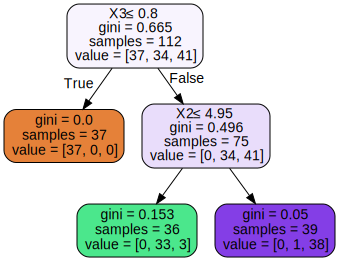

In [9]:
dot_data = tree.export_graphviz(estimator, 
                          filled=True, rounded=True,  
                          special_characters=True)  
graphviz.Source(dot_data)  

In [4]:
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

In [103]:
class NewTree(object):
    def __init__(self, n_nodes, children_left, children_right, features, thresholds, labels):
        self.n_nodes = np.array(n_nodes)
        self.children_left = np.array(children_left)
        self.children_right = np.array(children_right)
        self.features = np.array(features)
        self.thresholds = np.array(thresholds)
        self.labels = np.array(labels)
        
        self.nodes = None
    
    def build_tree(self):
        nodes = []
        for node in range(self.n_nodes):
            if (len(np.argwhere(self.children_right == node))==0) and (len(np.argwhere(self.children_left == node))==0):
                ancestor = None
            else:
                if len(np.argwhere(self.children_right == node))!=0:
                    ancestor = np.argwhere(self.children_right == node).ravel()[0]
                else:
                    ancestor = np.argwhere(self.children_left == node).ravel()[0]
            new_node = Node(self.children_left[node], 
                            self.children_right[node],
                            ancestor,
                            self.features[node], 
                            self.thresholds[node], 
                            self.labels[node])
            nodes.append(new_node)
        for node in nodes:
            node.left = nodes[node.idxleft] if node.idxleft != -1 else None
            node.right = nodes[node.idxright] if node.idxright != -1 else None
        self.nodes = nodes

class Node: 
    def __init__(self, idxleft, idxright, ancestor, feature, threshold, label): 
        #self.key = key 
        self.idxleft = idxleft
        self.idxright = idxright
        self.ancestor = ancestor
        self.feature = feature
        self.threshold = threshold
        self.label = label
        self.left = None
        self.right = None

In [105]:
INT_MAX = 200
def closestDown(root): 
    #Base Case 
    if root is None: 
        return INT_MAX 
    if root.left is None and root.right is None: 
        return 0
      
    # Return minum of left and right plus one 
    return 1 + min(closestDown(root.left), 
                   closestDown(root.right))

def findClosestUtil(root, k, ancestors, index): 
    # Base Case  
    if root is None: 
        return INT_MAX 
      
    # if key found 
    if root.key == k: 
        # Find closest leaf under the subtree rooted 
        # with given key 
        res = closestDown(root) 
          
        # Traverse ll ancestors and update result if any 
        # parent node gives smaller distance 
        for i in reversed(range(0,index)): 
            res = min(res, index-i+closestDown(ancestors[i])) 
        return res 
  
    # if key node found, store current node and recur for left 
    # and right childrens 
    ancestors[index] = root 
    return min( 
        findClosestUtil(root.left, k,ancestors, index+1), 
        findClosestUtil(root.right, k, ancestors, index+1)) 

In [109]:
closestDown(a.nodes[3])

0

In [48]:
np.argwhere(children_left == 1)

array([[0]])

In [11]:
children_left

array([ 1, -1,  3, -1, -1])

In [12]:
children_right

array([ 2, -1,  4, -1, -1])

In [13]:
feature

array([ 3, -2,  2, -2, -2])

In [14]:
threshold

array([ 0.80000001, -2.        ,  4.95000005, -2.        , -2.        ])

In [56]:
estimator.tree_.value.argmax(axis=2).ravel()

array([2, 0, 2, 1, 2])

In [104]:
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
features = estimator.tree_.feature
thresholds = estimator.tree_.threshold
labels = estimator.tree_.value.argmax(axis=2).ravel()
a=NewTree(n_nodes, children_left, children_right, features, thresholds, labels)
a.build_tree()

In [90]:
a.nodes[4].ancestor

2

In [18]:
dir(estimator.tree_)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'apply',
 'capacity',
 'children_left',
 'children_right',
 'compute_feature_importances',
 'compute_partial_dependence',
 'decision_path',
 'feature',
 'impurity',
 'max_depth',
 'max_n_classes',
 'n_classes',
 'n_features',
 'n_leaves',
 'n_node_samples',
 'n_outputs',
 'node_count',
 'predict',
 'threshold',
 'value',
 'weighted_n_node_samples']

In [6]:
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
labels = estimator.tree_.value.argmax(axis=2).ravel()


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 5 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 leaf node.
		node=4 leaf node.



In [7]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 3] (= 2.4) > 0.800000011920929)
decision id node 2 : (X_test[0, 2] (= 5.1) > 4.950000047683716)


In [8]:
# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))


The following samples [0, 1] share the node [0 2] in the tree
It is 40.0 % of all nodes.
